Import data from previous notebook and librairies

In [41]:
import pandas as pd
import shap
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import Lasso, Ridge, ElasticNet, LinearRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from scipy.stats import uniform
from tqdm import tqdm
import time

shap.initjs()
pd.options.display.float_format = '{:.6f}'.format
data = pd.read_csv('X_clean.csv')
data_energystar = pd.read_csv('X_clean_with_energystar.csv')

data.head()


,TotalGHGEmissions,SiteEnergyUse(kBtu),NumberofBuildings,NumberofFloors,PropertyGFABuilding(s),Age,Latitude,Longitude,RatioElectricityUse,RatioNaturalGasUse,...,Residential Care Facility,Restaurant,Retail Store,Self-Storage Facility,Senior Care Community,Social/Meeting Hall,Strip Mall,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Worship Facility
0,249.980000,7226362.500000,1.000000,12,88434,97,47.612200,-122.337990,0.160041,0.001766,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,295.860000,8387933.000000,1.000000,11,88502,28,47.613170,-122.333930,0.113309,0.006134,...,0.000000,4622.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2089.280000,72587024.000000,1.000000,41,759392,55,47.613930,-122.338100,0.199973,0.000206,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,286.430000,6794584.000000,1.000000,10,61320,98,47.614120,-122.336640,0.119437,0.002666,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,505.010000,14172606.000000,1.000000,18,113580,44,47.613750,-122.340470,0.111020,0.006212,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Creation of class Data, where it setup all model, and have a public method run to benchmark differents model with the datasett using Kfold to try different setup of tain/test data.
All model use CV to setup best hyperparameters.

In [42]:
class SHAPAnalyzer:
    def __init__(self, model, X_train, X_test, mode, name):
        self.model = model
        self.X_train = X_train
        self.X_test = X_test
        self.mode = mode
        print(name)
    
    def calculate_and_plot_shap_global(self):
        if self.mode >= 4:
            explainer = shap.TreeExplainer(self.model)
        else:
            explainer = shap.LinearExplainer(self.model, self.X_train)
        shap_values = explainer(self.X_train)
        shap.summary_plot(shap_values, self.X_train)
        return shap_values
    
    def calculate_and_plot_shap_local(self, instance_index=0):
        if self.mode >= 4:
            explainer = shap.TreeExplainer(self.model)
        else:
            explainer = shap.LinearExplainer(self.model, self.X_train)
        shap_values = explainer(self.X_test)
        shap_values_instance = shap_values[instance_index]
        shap.force_plot(
            explainer.expected_value,
            shap_values_instance.values,
            self.X_test.iloc[instance_index],
            matplotlib=True
        )
        return shap_values_instance


In [43]:
def show_result(res):
    list_r2  = ['linear R2', 'ridge R2', 'lasso R2', 'elastic R2','random forest R2','xgboost R2']
    res[list_r2] = res[list_r2].clip(lower=-1, upper=1)

    scores_r2 = res[list_r2].mean().reset_index()
    print(scores_r2)
    scores_r2.columns = ['Model', 'Mean R²']
    sns.barplot(x='Model', y='Mean R²', data=scores_r2)
    plt.xticks(rotation=45, ha='right')
    plt.show()

In [44]:
def show_time(res):
    time = res[['linear time',	'ridge time',	'lasso time',	'elastic time',	'random forest time',	'xgboost time']].mean().reset_index()
    print(time)
    time.columns = ['Model', 'Mean Time']
    sns.barplot(x='Model', y='Mean Time', data=time)
    plt.xticks(rotation=45, ha='right')
    plt.show()

In [45]:
class Data:
    def __init__(self, data, y_n):
        self.epoch = 5
        self.n_jobs = 10
        self.layout = {
            'linear R2': [],
            'ridge R2': [],
            'lasso R2': [],
            'elastic R2': [],
            'random forest R2': [],
            'xgboost R2': [],
            'ridge alpha': [],
            'lasso alpha': [],
            'elastic alpha': [],
            'elastic l1_ratio': [],
            'random forest params': [],
            'xgboost params': [],
            'linear time': [],
            'ridge time': [],
            'lasso time': [],
            'elastic time': [],
            'random forest time': [],
            'xgboost time': []
        }
        self.name_list = ['linear', 'ridge', 'lasso', 'elastic', 'random forest', 'xgboost']
        self.iter = 0
        self.origin = data.copy()
        self.y_n = y_n
        self.data = data
        self.y = self.data.iloc[:, y_n]
        self.data = self.data.iloc[:, 2:]
        print(f"Prediction {self.y.name}")
        
    def preprocess(self, train, test):
        scaler = StandardScaler()
        df_train = pd.DataFrame(scaler.fit_transform(train), columns=self.data.columns)
        df_test = pd.DataFrame(scaler.transform(test), columns=self.data.columns)
        return df_train, df_test
           
    def run(self):
        kf = KFold(n_splits=self.epoch, shuffle=True, random_state=42)
        self.models = [
            LinearRegression(),
            Ridge(),
            Lasso(),
            ElasticNet(),
            RandomForestRegressor(),
            xgb.XGBRegressor()
        ]
        total_steps_per_epoch = 6
        with tqdm(total=kf.get_n_splits() * total_steps_per_epoch, desc="Epoch Progress") as pbar:
            for train_index, test_index in kf.split(self.data):
                self.X_train, self.X_test = self.data.iloc[train_index], self.data.iloc[test_index]
                self.y_train, self.y_test = self.y.iloc[train_index], self.y.iloc[test_index]
                self.X_train, self.X_test = self.preprocess(self.X_train, self.X_test)
                self.models[0] = self.linear_regression(self.models[0])
                pbar.update(1)
                self.models[1] = self.ridge_regression(self.models[1])
                pbar.update(1)
                self.models[2] = self.lasso_regression(self.models[2])
                pbar.update(1)
                self.models[3] = self.elastic_net(self.models[3])
                pbar.update(1)
                self.models[4] = self.random_forest_regression(self.models[4])
                pbar.update(1)
                self.models[5] = self.xgboost_regression(self.models[5])
                pbar.update(1)
            for i in range(len(self.models)):
                explainer = SHAPAnalyzer(self.models[i], self.X_train, self.X_test, i, self.name_list[i])
                explainer.calculate_and_plot_shap_global()
                explainer.calculate_and_plot_shap_local()
        return self.layout

    def linear_regression(self, model):
        start_time = time.time()
        model.fit(self.X_train, self.y_train)
        pred = model.predict(self.X_test)
        explainer = shap.Explainer(model, self.X_train)
        shap_values = explainer(self.X_test)
        end_time = time.time()
        self.layout['linear R2'].append(r2_score(self.y_test, pred))
        self.layout['linear time'].append(end_time - start_time)
        shap.plots.force(shap_values[0])
        return model

    def ridge_regression(self, model):
        start_time = time.time()
        param_distributions_ridge = {'alpha': uniform(0.01, 1000)}
        random_search_ridge = RandomizedSearchCV(model, param_distributions_ridge, n_iter=20, cv=5, scoring='r2', n_jobs=self.n_jobs)
        random_search_ridge.fit(self.X_train, self.y_train)
        best_ridge = random_search_ridge.best_estimator_
        pred = best_ridge.predict(self.X_test)
        end_time = time.time()
        self.layout['ridge R2'].append(r2_score(self.y_test, pred))
        self.layout['ridge alpha'].append(random_search_ridge.best_params_['alpha'])
        self.layout['ridge time'].append(end_time - start_time)
        return best_ridge

    def lasso_regression(self, model):
        start_time = time.time()
        param_distributions_lasso = {'alpha': uniform(0.01, 1000)}
        random_search_lasso = RandomizedSearchCV(model, param_distributions_lasso, n_iter=20, cv=5, scoring='r2', n_jobs=self.n_jobs)
        random_search_lasso.fit(self.X_train, self.y_train)
        best_lasso = random_search_lasso.best_estimator_
        pred = best_lasso.predict(self.X_test)
        end_time = time.time()
        self.layout['lasso R2'].append(r2_score(self.y_test, pred))
        self.layout['lasso alpha'].append(random_search_lasso.best_params_['alpha'])
        self.layout['lasso time'].append(end_time - start_time)
        return best_lasso

    def elastic_net(self, model):
        start_time = time.time()
        param_distributions_elastic_net = {
            'alpha': uniform(0.01, 1000),
            'l1_ratio': uniform(0, 1)
        }
        random_search_elastic_net = RandomizedSearchCV(model, param_distributions_elastic_net, n_iter=20, cv=5, scoring='r2', n_jobs=self.n_jobs)
        random_search_elastic_net.fit(self.X_train, self.y_train)
        best_elastic_net = random_search_elastic_net.best_estimator_
        pred = best_elastic_net.predict(self.X_test)
        end_time = time.time()
        self.layout['elastic R2'].append(r2_score(self.y_test, pred))
        self.layout['elastic alpha'].append(random_search_elastic_net.best_params_['alpha'])
        self.layout['elastic l1_ratio'].append(random_search_elastic_net.best_params_['l1_ratio'])
        self.layout['elastic time'].append(end_time - start_time)
        return best_elastic_net

    def random_forest_regression(self, model):
        start_time = time.time()
        param_grid_rf = {
            'n_estimators': [50, 100],
            'max_depth': [10, 20],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2]
        }
        random_search_rf = GridSearchCV(model, param_grid_rf, cv=5, scoring='r2', n_jobs=self.n_jobs)
        random_search_rf.fit(self.X_train, self.y_train)
        best_rf = random_search_rf.best_estimator_
        pred = best_rf.predict(self.X_test)
        end_time = time.time()
        self.layout['random forest R2'].append(r2_score(self.y_test, pred))
        self.layout['random forest params'].append(random_search_rf.best_params_)
        self.layout['random forest time'].append(end_time - start_time)
        return best_rf

    def xgboost_regression(self, model):
        start_time = time.time()
        param_distributions_xgb = {
            'n_estimators': [10, 50, 100],
            'max_depth': [3, 6, 10],
            'learning_rate': uniform(0.01, 0.3),
            'alpha': uniform(0, 1)
        }
        random_search_xgb = RandomizedSearchCV(model, param_distributions_xgb, n_iter=20, cv=5, scoring='r2', n_jobs=self.n_jobs)
        random_search_xgb.fit(self.X_train, self.y_train)
        best_xgb = random_search_xgb.best_estimator_
        pred = best_xgb.predict(self.X_test)
        end_time = time.time()
        self.layout['xgboost R2'].append(r2_score(self.y_test, pred))
        self.layout['xgboost params'].append(random_search_xgb.best_params_)
        self.layout['xgboost time'].append(end_time - start_time)
        return best_xgb

Transorme the result from the class method run to dataframe to use it later and run the test

Prediction TotalGHGEmissions


Epoch Progress: 100%|██████████| 30/30 [01:58<00:00,  5.97s/it]

linear


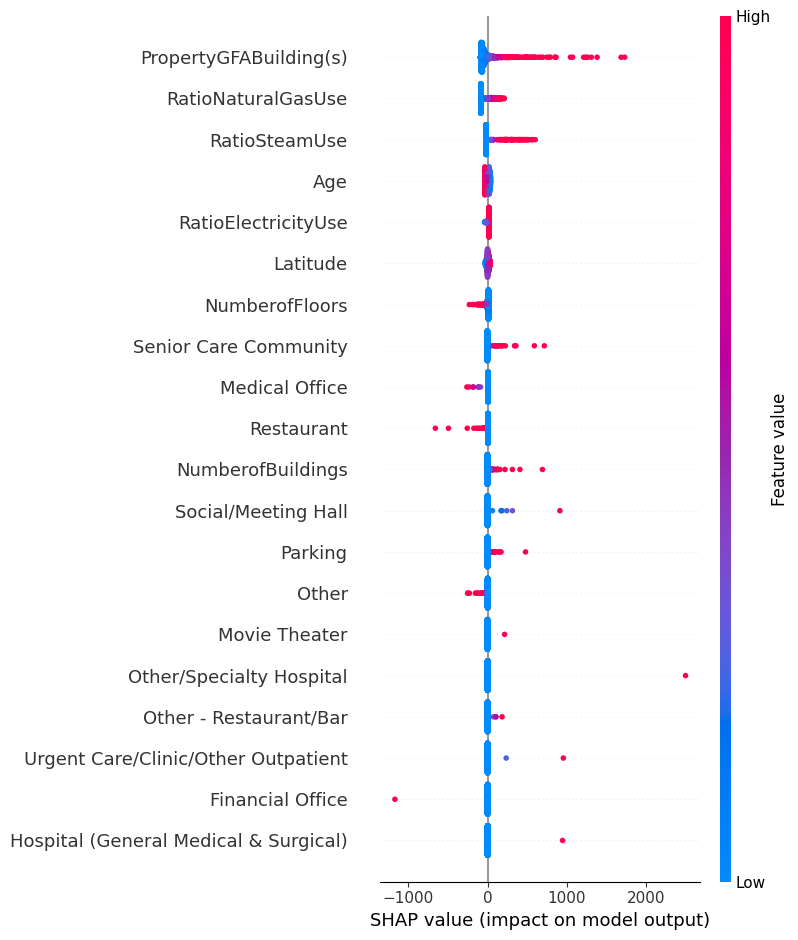

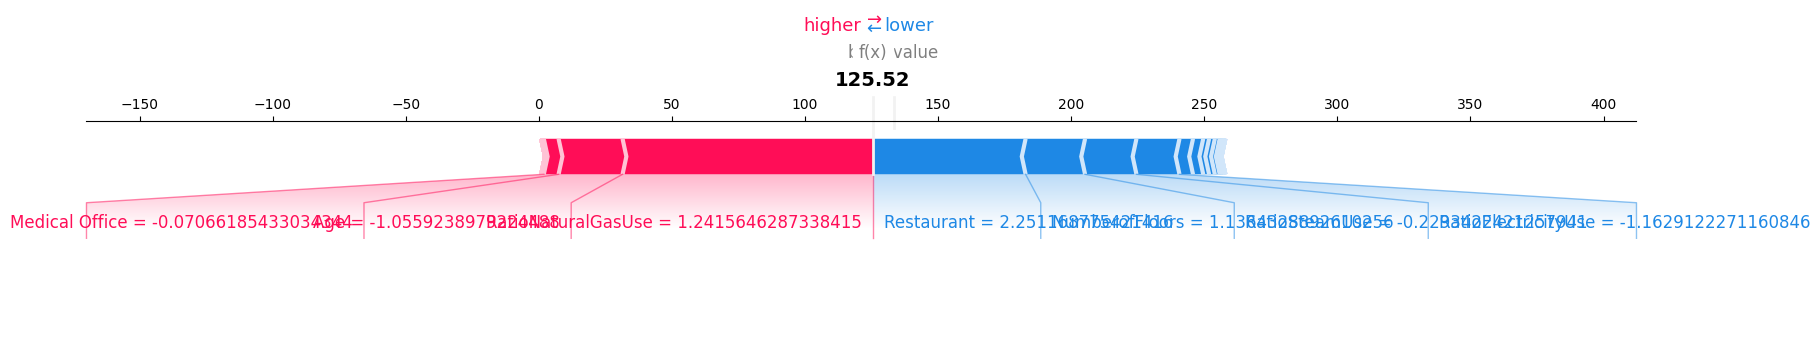

ridge


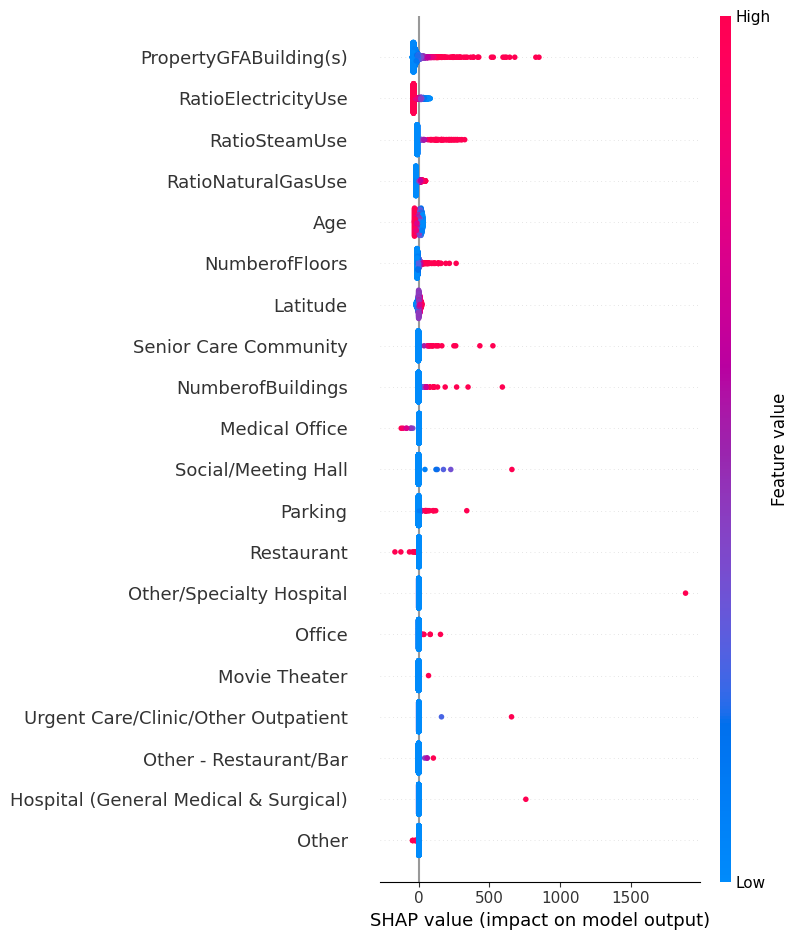

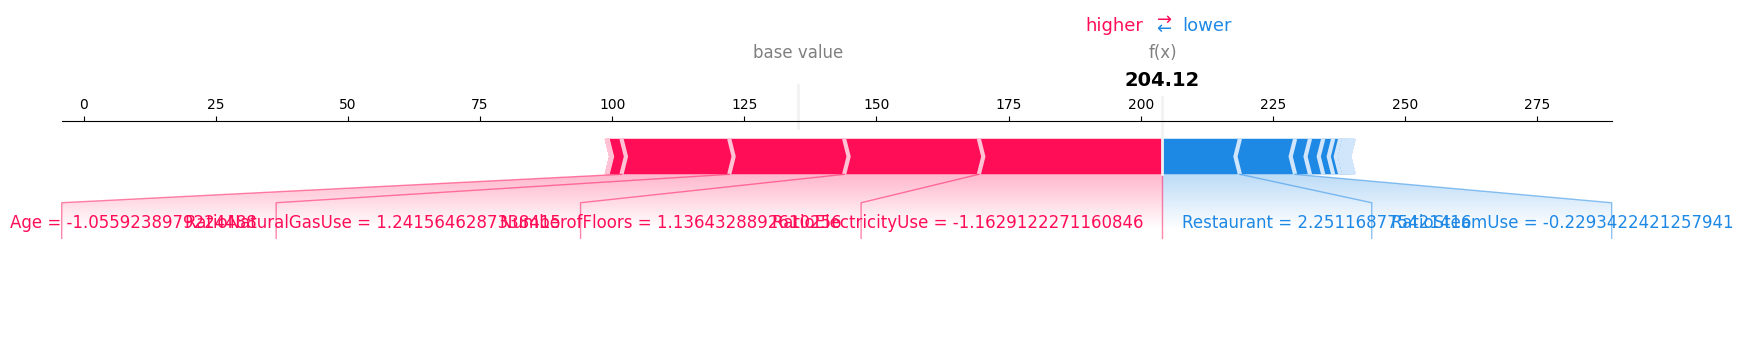

lasso


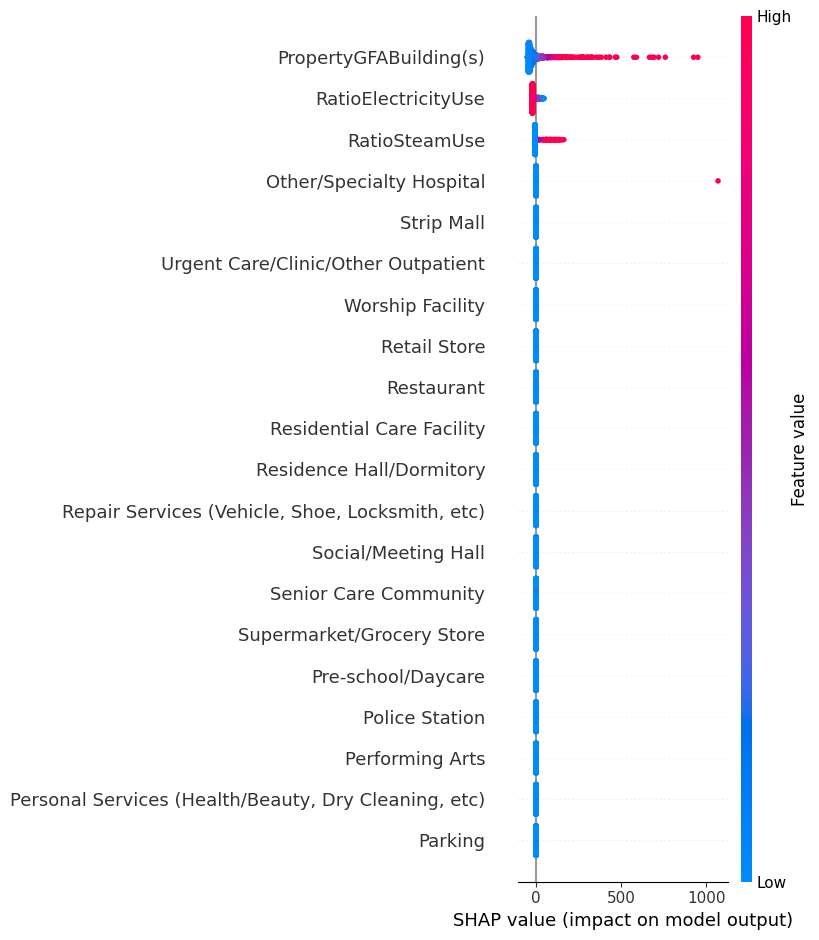

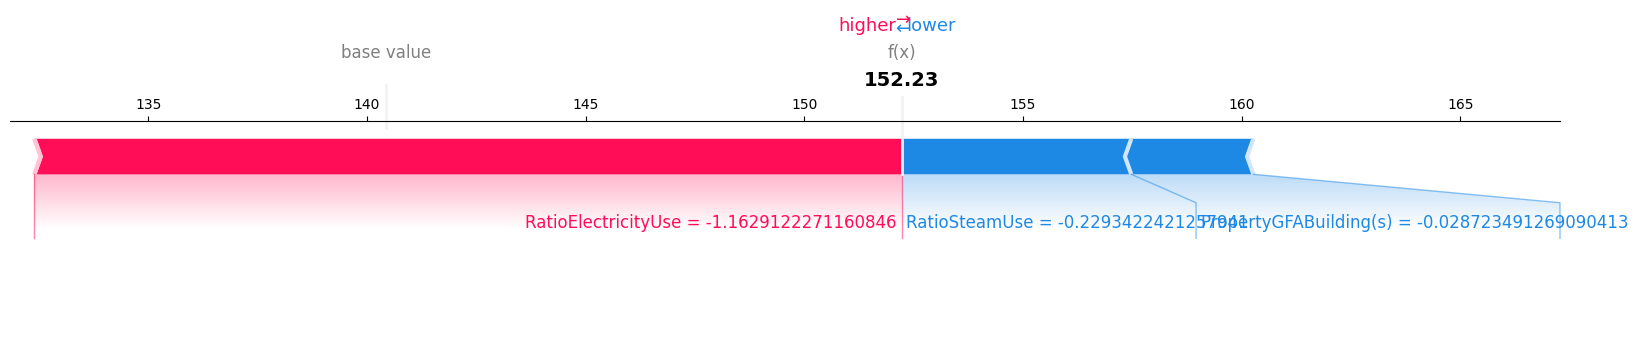

elastic


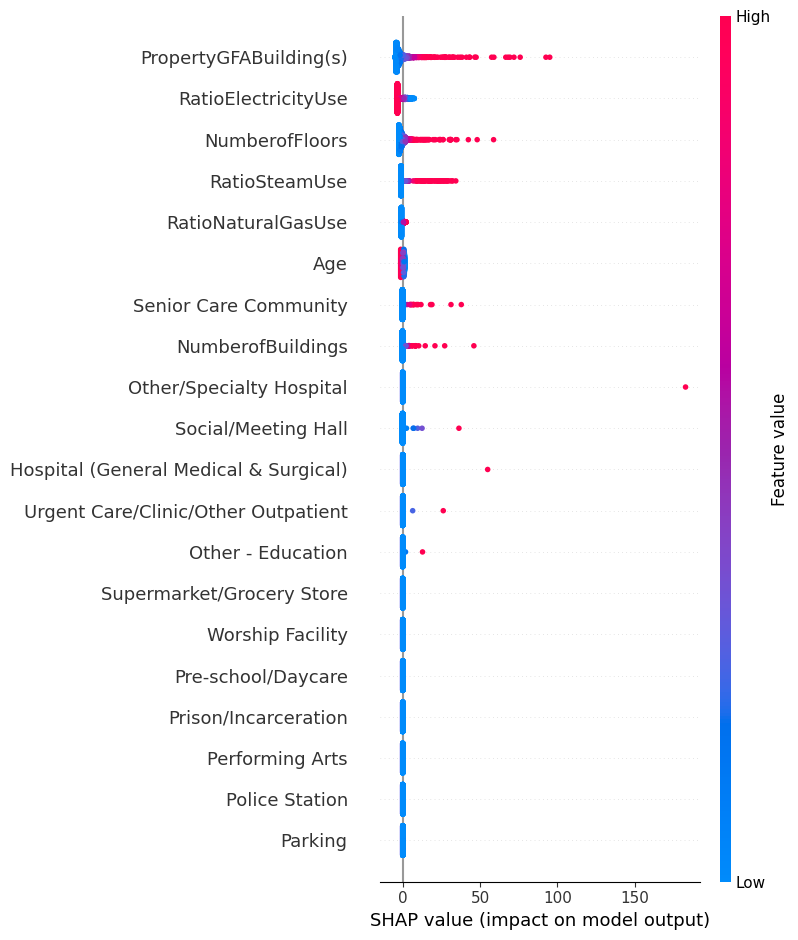

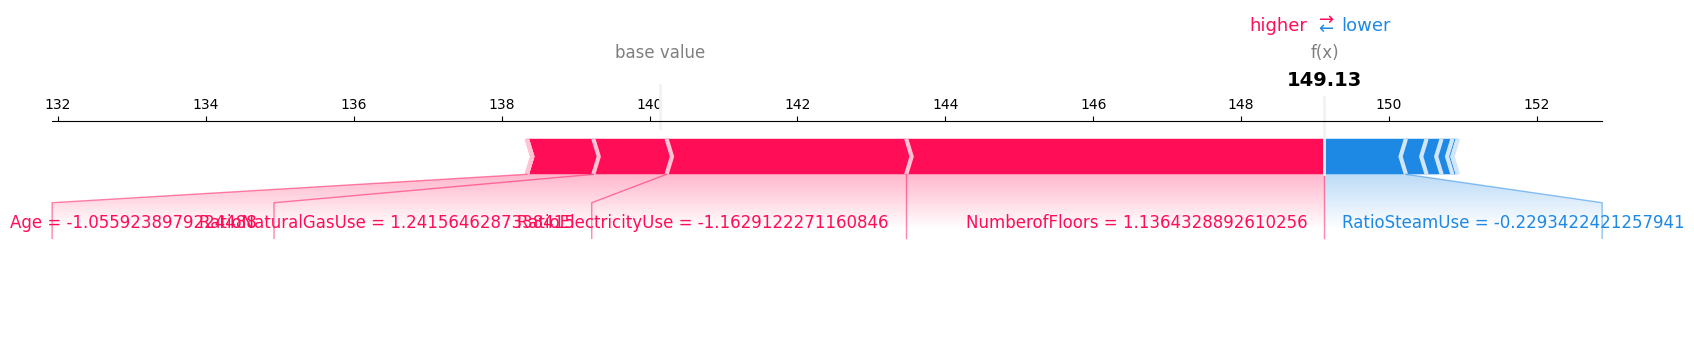

random forest


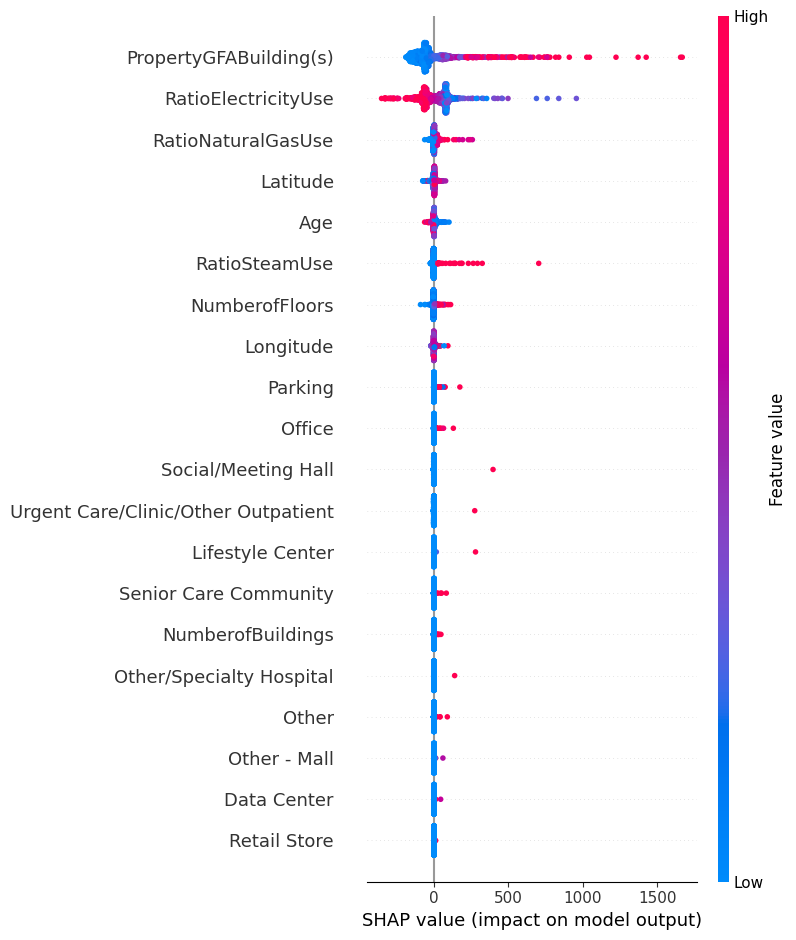

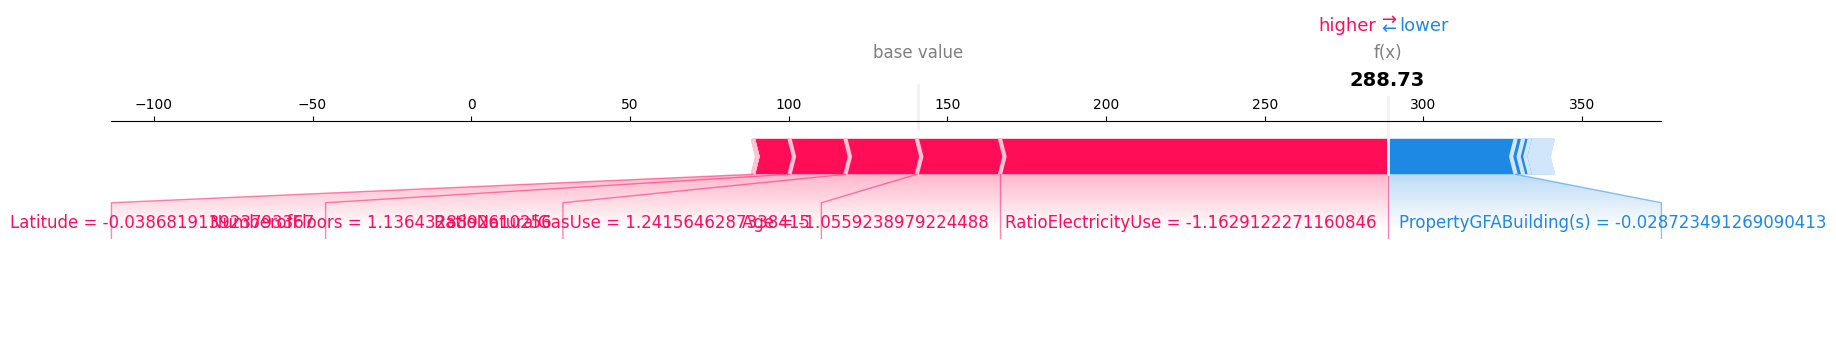

xgboost


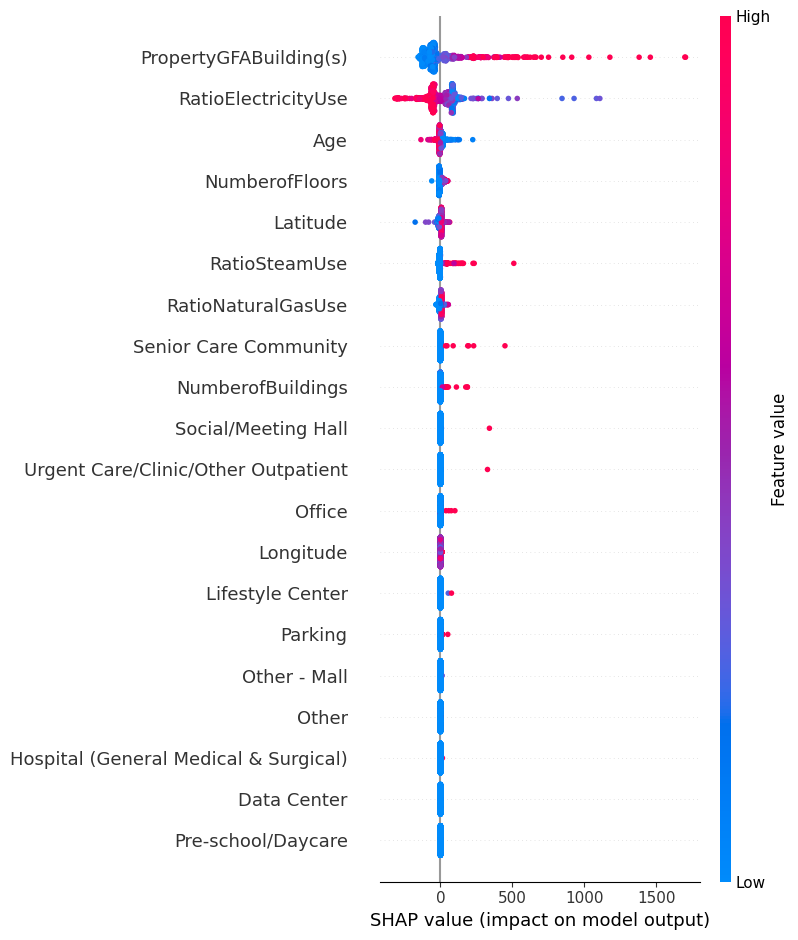

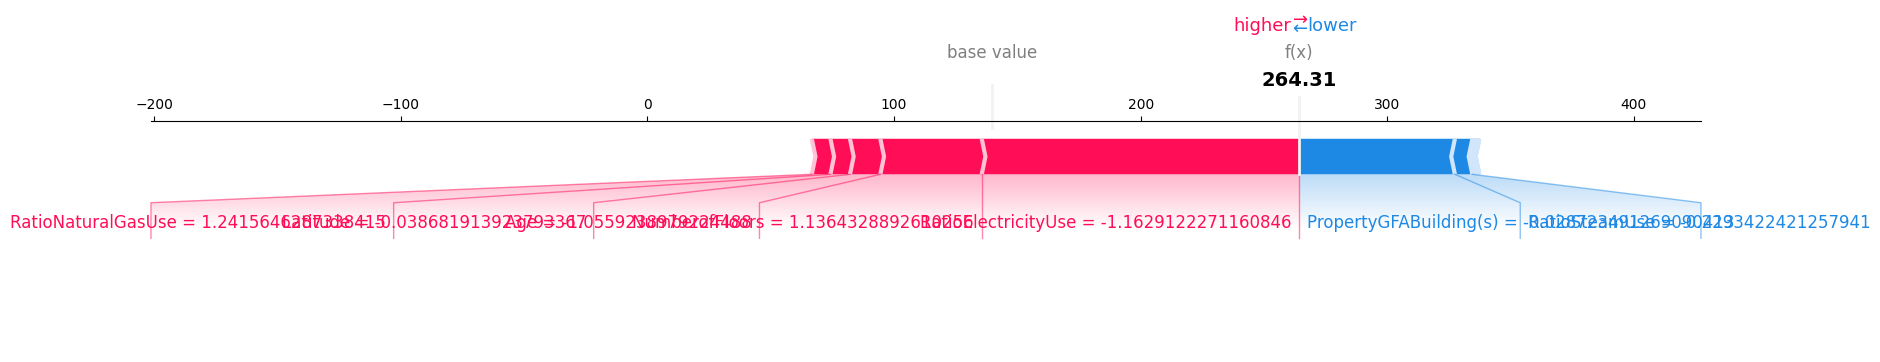

Epoch Progress: 100%|██████████| 30/30 [02:12<00:00,  4.41s/it]


,linear R2,ridge R2,lasso R2,elastic R2,random forest R2,xgboost R2,ridge alpha,lasso alpha,elastic alpha,elastic l1_ratio,random forest params,xgboost params,linear time,ridge time,lasso time,elastic time,random forest time,xgboost time
0,-11267156631912828930470998704128.000000,0.226755,0.180171,0.121818,0.540926,0.478458,331.276355,24.076417,29.253788,0.652277,"{'max_depth': 20, 'min_samples_leaf': 2, 'min_...","{'alpha': 0.49400086724936876, 'learning_rate'...",0.024303,0.211485,0.247363,0.271490,15.422327,6.960093
1,-8684381156596876989664843530240.000000,0.331278,0.336617,0.001540,0.555172,0.543660,149.441404,7.488779,258.542400,0.127914,"{'max_depth': 20, 'min_samples_leaf': 2, 'min_...","{'alpha': 0.4838365263738976, 'learning_rate':...",0.079440,0.248188,0.251308,0.251442,15.262890,7.710747
2,0.318733,0.344666,0.367551,0.018505,0.623558,0.693754,131.659654,6.084572,59.913923,0.554214,"{'max_depth': 20, 'min_samples_leaf': 1, 'min_...","{'alpha': 0.31326113838096303, 'learning_rate'...",0.107245,0.240726,0.254146,0.270110,16.360393,6.970433
3,-146816363458374259285568782336.000000,0.314572,0.133591,0.156543,0.510734,0.541151,113.081917,94.014260,11.676944,0.803930,"{'max_depth': 10, 'min_samples_leaf': 1, 'min_...","{'alpha': 0.43626391497871186, 'learning_rate'...",0.105032,0.234709,0.245120,0.255841,16.493831,7.082185
4,0.241870,0.247051,0.269001,0.049724,0.755315,0.781356,610.059843,48.250640,32.005128,0.628833,"{'max_depth': 10, 'min_samples_leaf': 1, 'min_...","{'alpha': 0.6132479560382943, 'learning_rate':...",0.325613,0.392984,0.311834,0.320981,16.134108,5.651944


In [46]:
import time

df = Data(data, 0)

res = pd.DataFrame(df.run())
res.head()

Calculation of means to compare all model and visualisation - R2

              index         0
0         linear R2 -0.487879
1          ridge R2  0.292864
2          lasso R2  0.257386
3        elastic R2  0.069626
4  random forest R2  0.597141
5        xgboost R2  0.607676


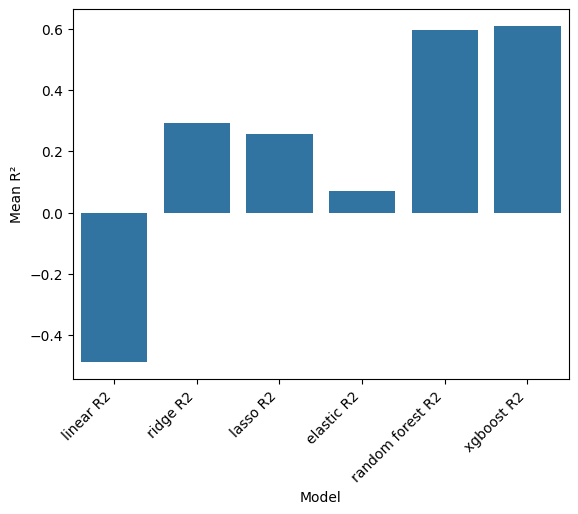

In [47]:
show_result(res)

xgboost have the best score but random forest is close

Calculation of means to compare all model and visualisation - time

                index         0
0         linear time  0.128327
1          ridge time  0.265618
2          lasso time  0.261954
3        elastic time  0.273973
4  random forest time 15.934710
5        xgboost time  6.875080


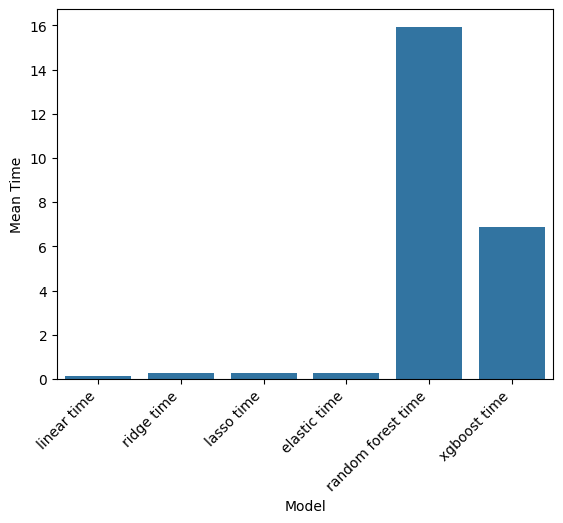

In [48]:
show_time(res)

the ones with the best time have very bad R2 score, so we keep only these 2 : random forest, xgboost

And xgboost have best score and exec time


Now try with the data with Energy star  

Prediction TotalGHGEmissions


Epoch Progress: 100%|██████████| 30/30 [02:15<00:00,  7.61s/it]

linear


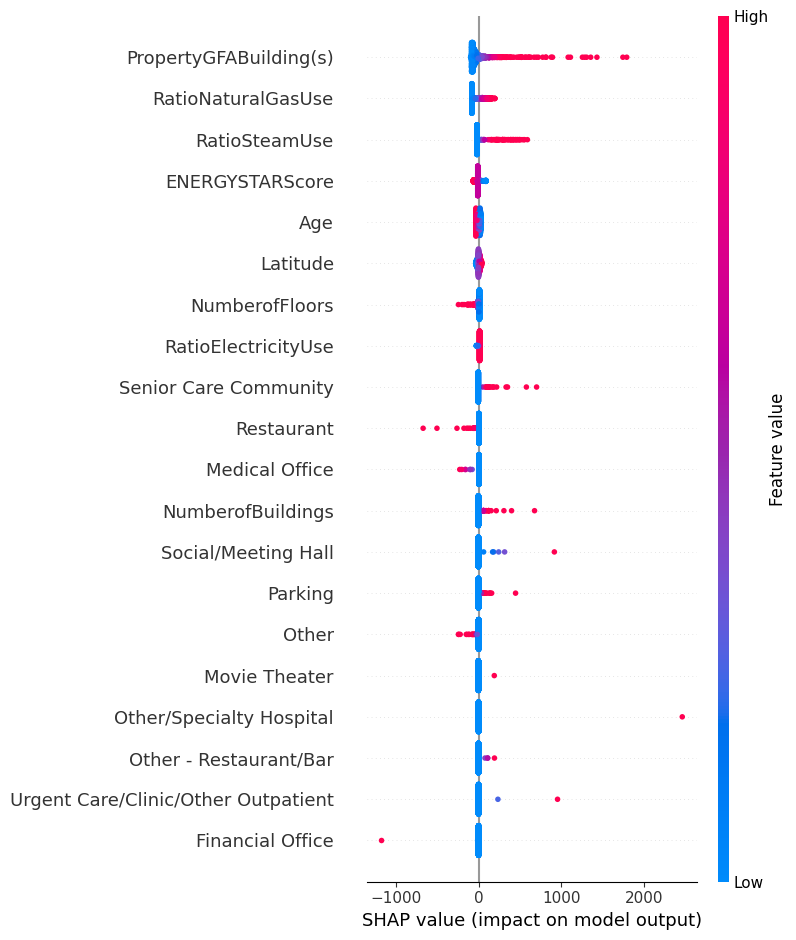

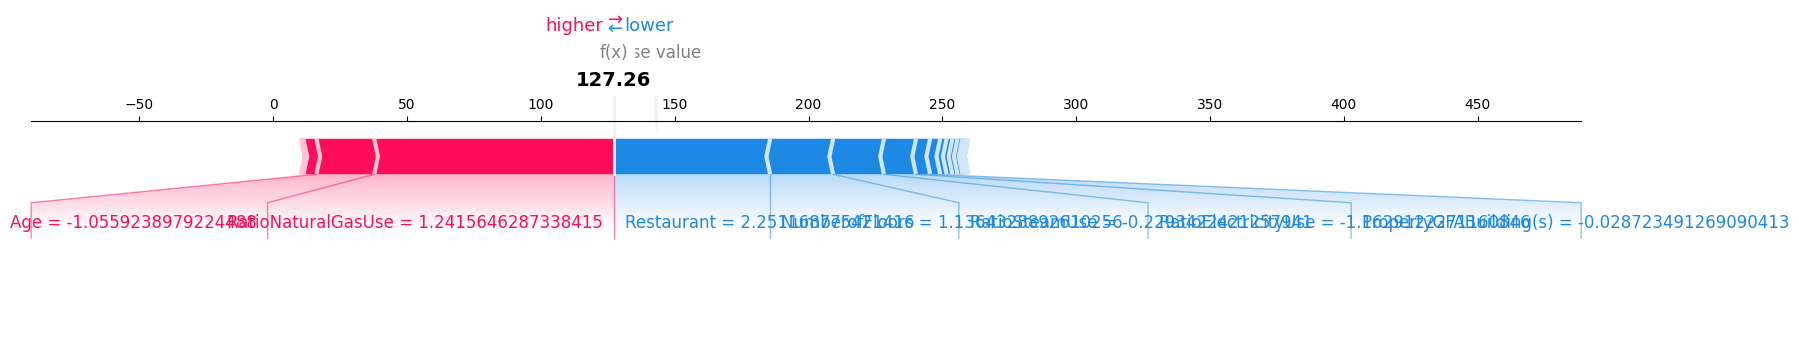

ridge


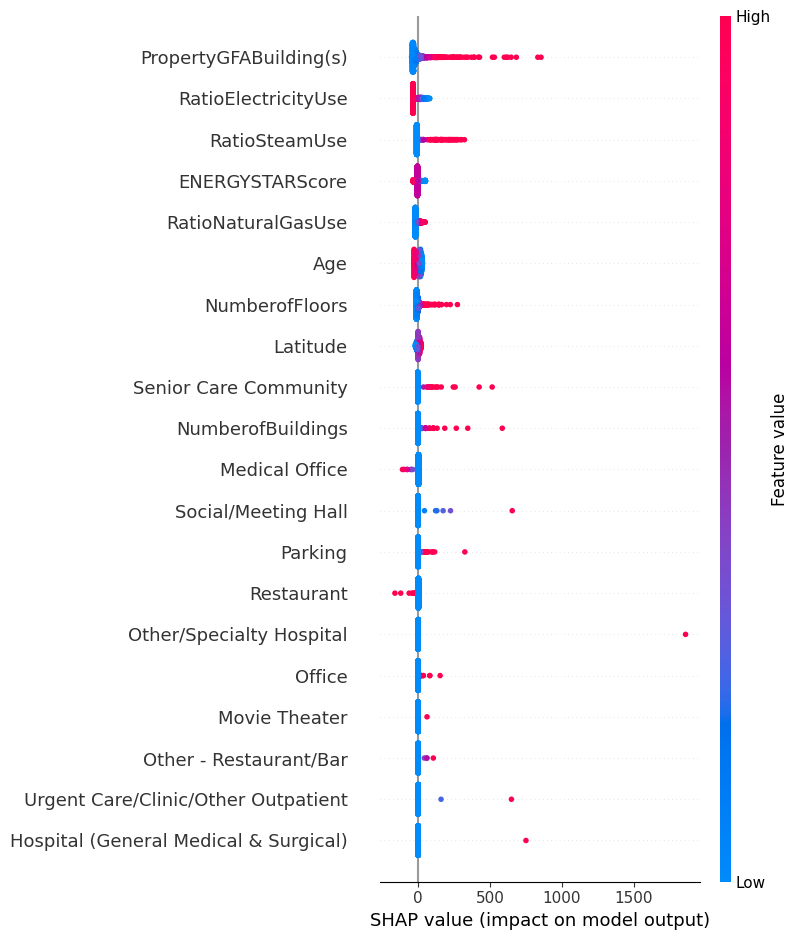

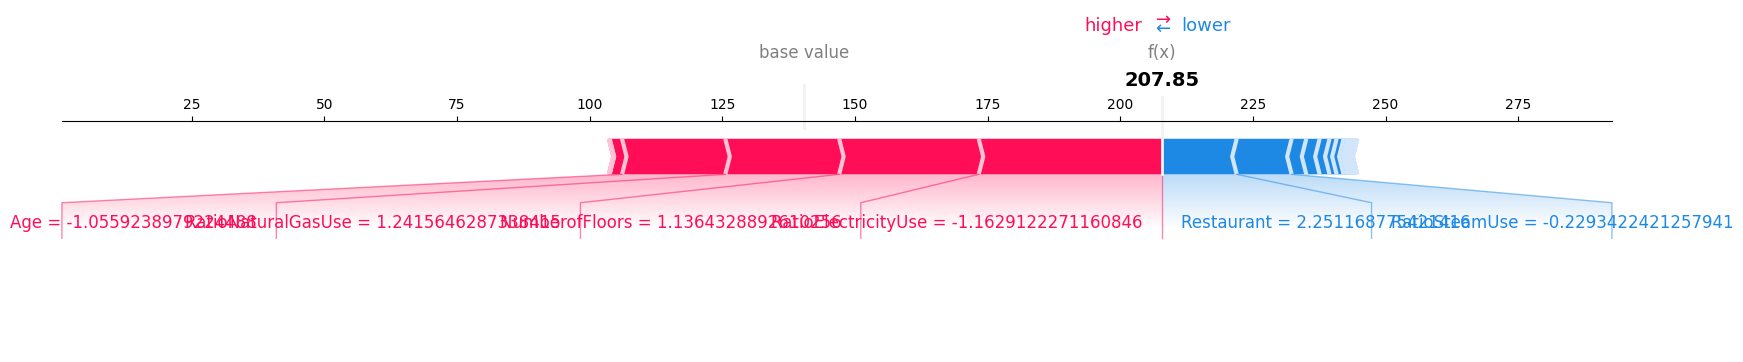

lasso


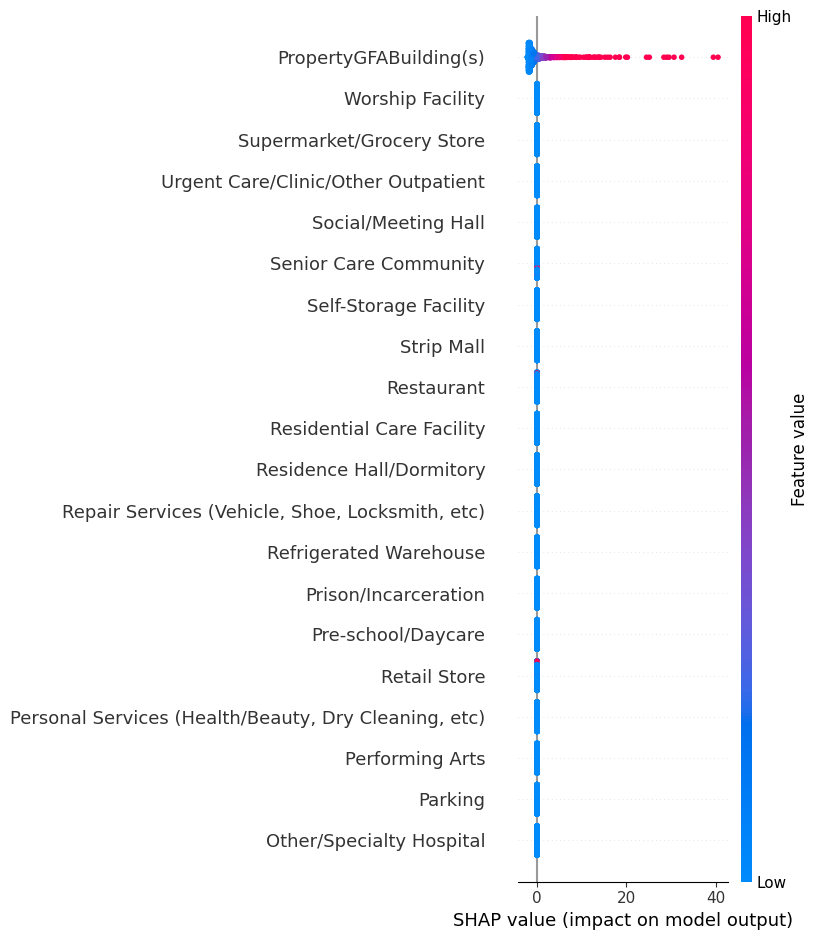

c:\Users\milan\Documents\oc\.oc\Lib\site-packages\shap\plots\_force_matplotlib.py:101: RuntimeWarning: divide by zero encountered in scalar divide
  feature_contribution = np.abs(float(feature[0]) - pre_val) / np.abs(total_effect)


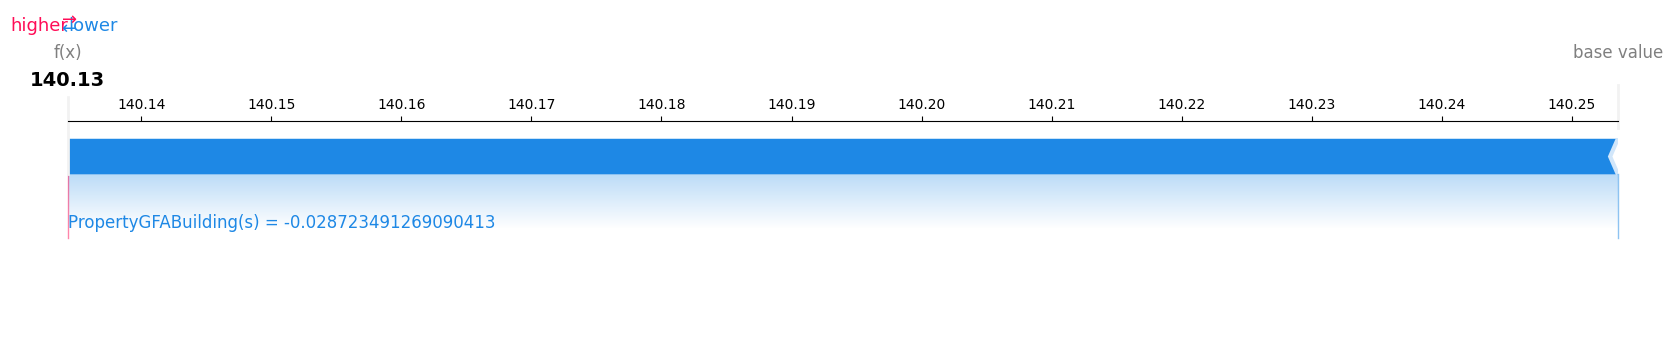

elastic


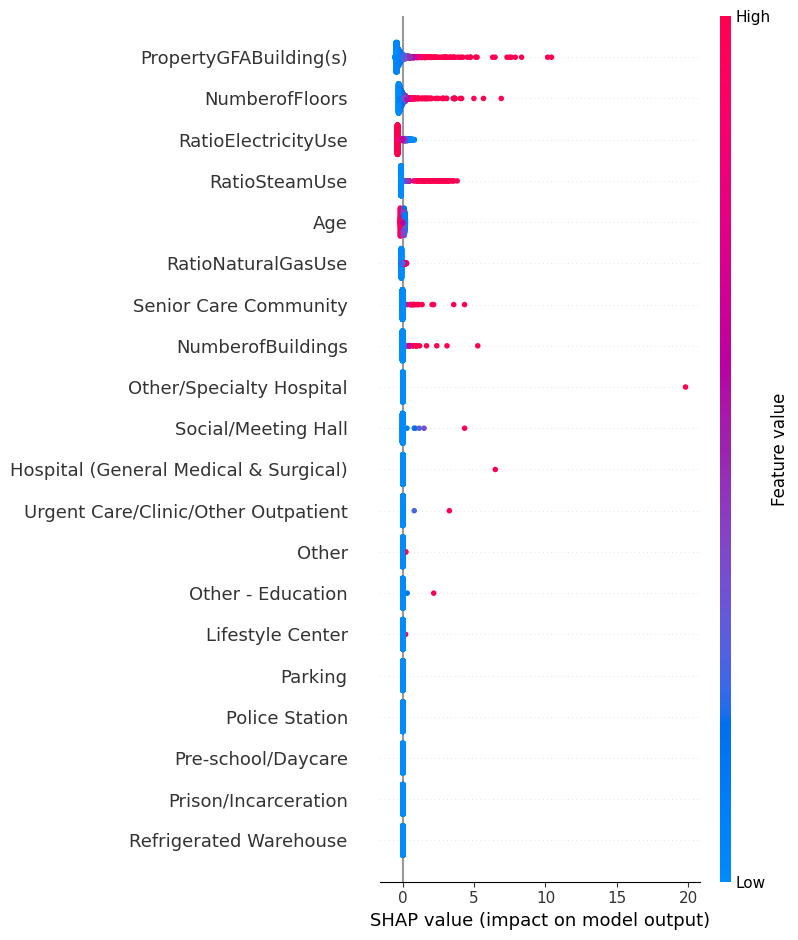

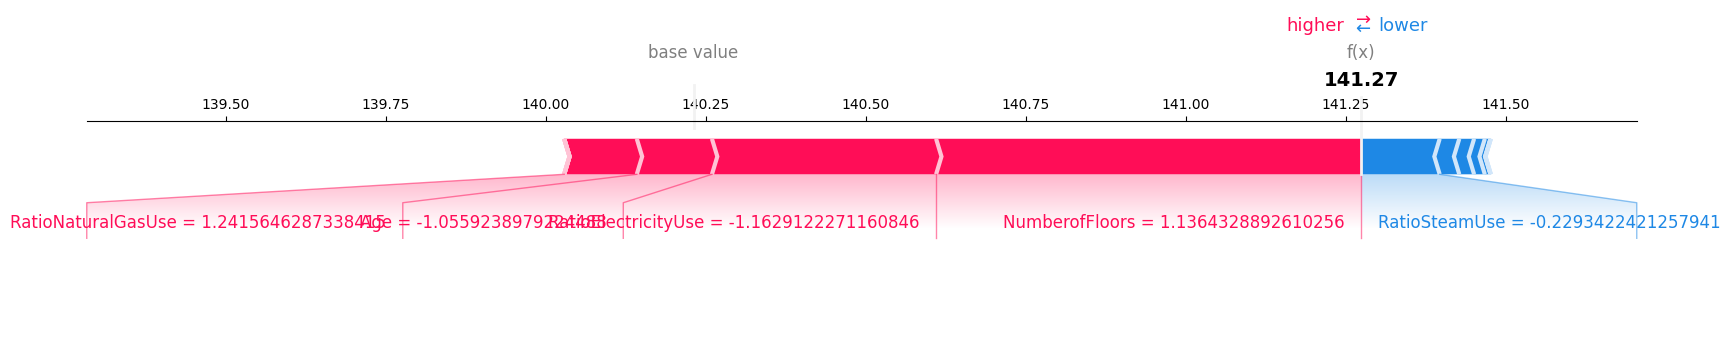

random forest


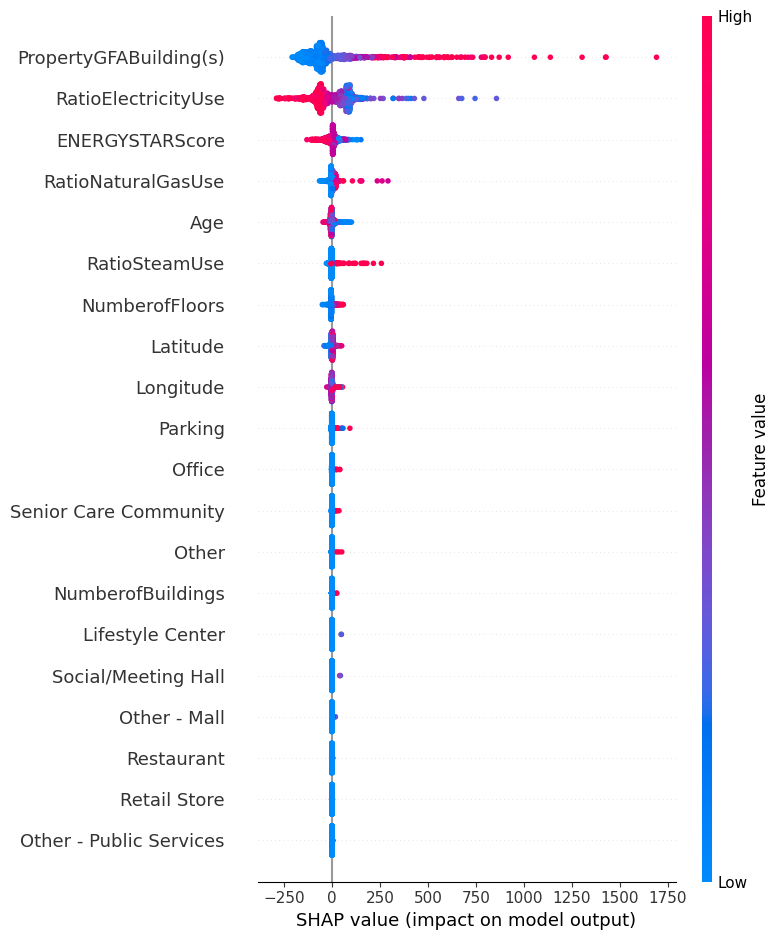

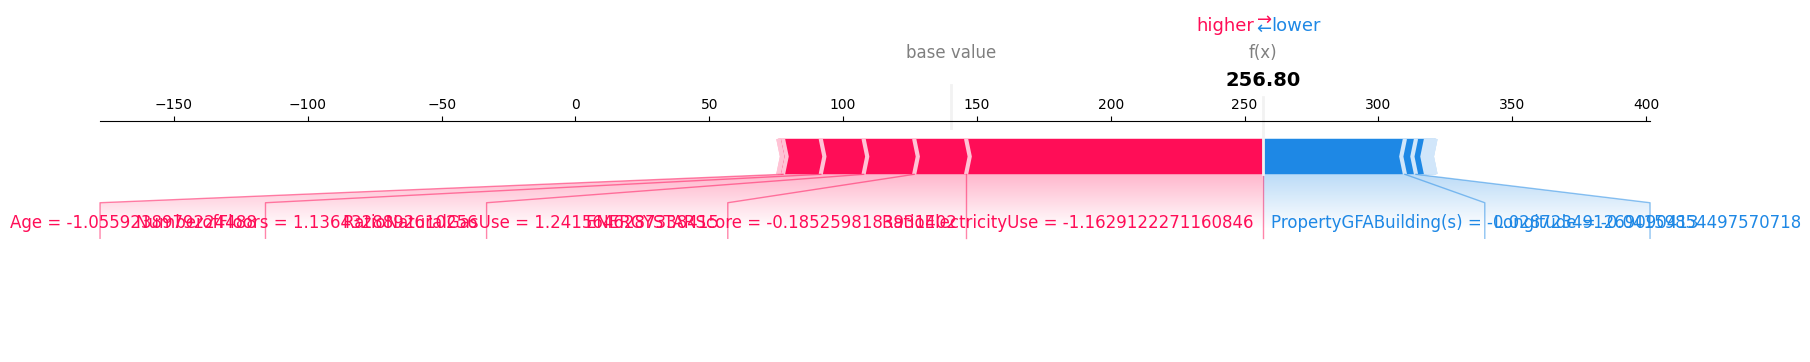

xgboost


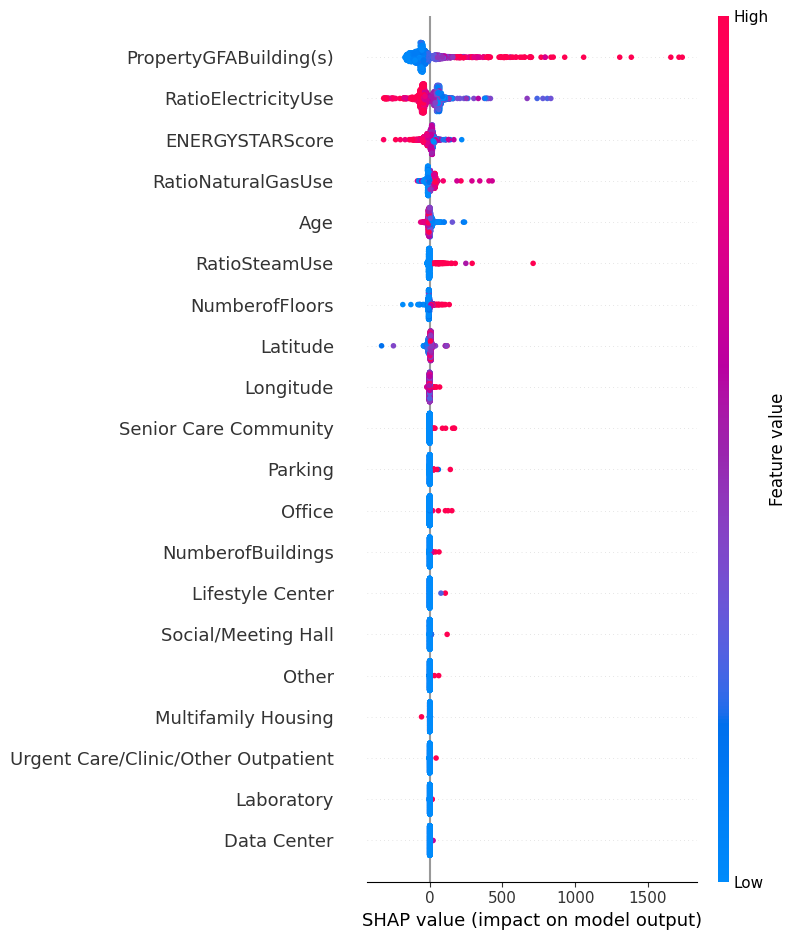

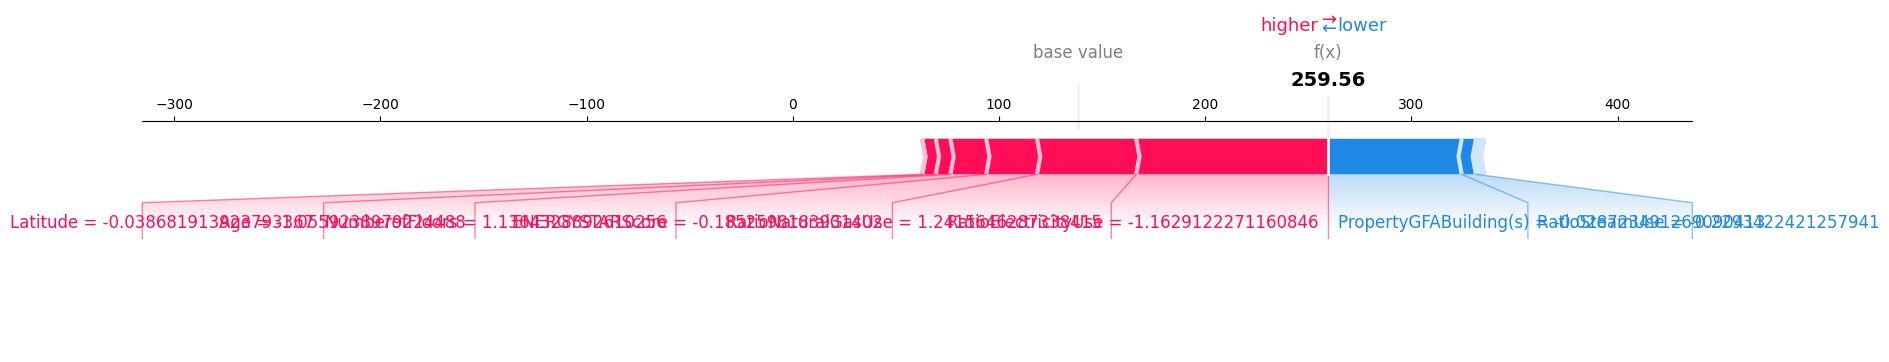

Epoch Progress: 100%|██████████| 30/30 [02:27<00:00,  4.93s/it]


,linear R2,ridge R2,lasso R2,elastic R2,random forest R2,xgboost R2,ridge alpha,lasso alpha,elastic alpha,elastic l1_ratio,random forest params,xgboost params,linear time,ridge time,lasso time,elastic time,random forest time,xgboost time
0,-13139200670401772144260418633728.000000,0.251674,0.208766,0.005333,0.588434,0.595925,335.740212,27.789674,257.589007,0.116685,"{'max_depth': 20, 'min_samples_leaf': 2, 'min_...","{'alpha': 0.3761612437918954, 'learning_rate':...",0.048776,0.276119,0.338638,0.332471,17.357557,8.059829
1,-2986197509139502943837960011776.000000,0.368085,0.231359,0.051849,0.615729,0.582038,136.695168,55.128430,21.985990,0.278598,"{'max_depth': 20, 'min_samples_leaf': 2, 'min_...","{'alpha': 0.6619430603508036, 'learning_rate':...",0.109714,0.258665,0.279984,0.290049,16.915971,8.541491
2,0.333658,0.357933,0.155437,0.272421,0.651491,0.709909,118.924425,96.049289,29.831193,0.990213,"{'max_depth': 20, 'min_samples_leaf': 2, 'min_...","{'alpha': 0.35230749808785533, 'learning_rate'...",0.274763,0.271723,0.268404,0.283526,16.431325,5.672797
3,-17350273630904375355037185998848.000000,0.323100,0.155655,0.050918,0.540856,0.465990,104.515136,75.857190,19.902122,0.402462,"{'max_depth': 20, 'min_samples_leaf': 1, 'min_...","{'alpha': 0.46140617220948765, 'learning_rate'...",0.111649,0.258074,0.268289,0.267748,19.477335,10.551883
4,0.334115,0.287831,0.013562,0.005512,0.761716,0.823018,631.498028,138.073369,140.626105,0.131444,"{'max_depth': 10, 'min_samples_leaf': 2, 'min_...","{'alpha': 0.9929757253189753, 'learning_rate':...",0.107746,0.335138,0.296469,0.304434,17.101708,9.857044


In [49]:
import time

df = Data(data_energystar, 0)

res_2 = pd.DataFrame(df.run())
res_2.head()

              index         0
0         linear R2 -0.466445
1          ridge R2  0.317725
2          lasso R2  0.152956
3        elastic R2  0.077206
4  random forest R2  0.631645
5        xgboost R2  0.635376


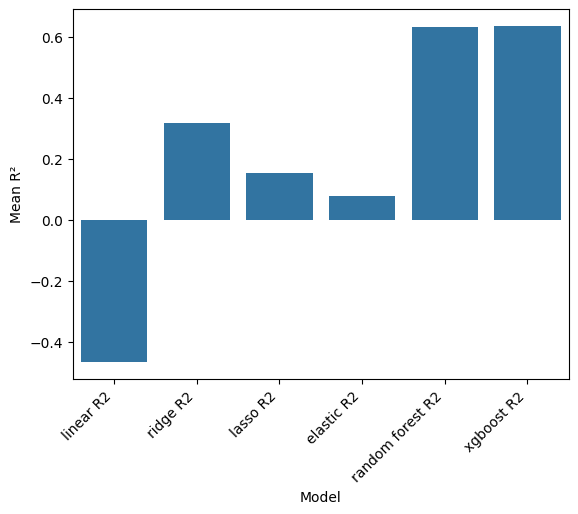

In [50]:
show_result(res_2)

                index         0
0         linear time  0.130529
1          ridge time  0.279944
2          lasso time  0.290357
3        elastic time  0.295646
4  random forest time 17.456779
5        xgboost time  8.536609


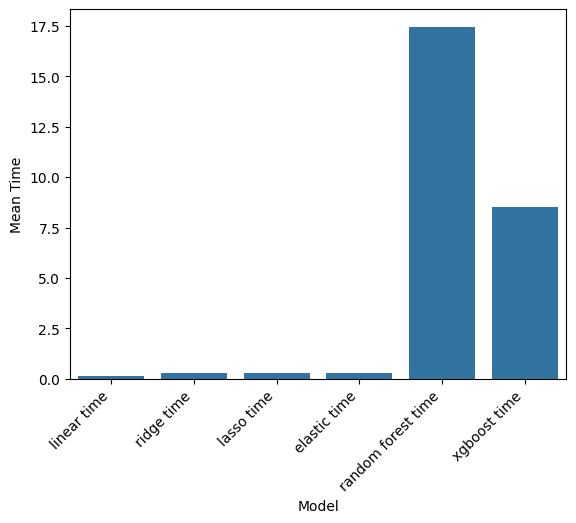

In [51]:
show_time(res_2)